# Diabetes Dataset Classification

LOAD DATA

In [79]:
import importlib
import functions
importlib.reload(functions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch 
import torch.nn as nn
import torch.optim as optim
from functions import scaled_tensorize_data, datasets_and_loaders, train_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


diabetes_data = pd.read_csv('DATASET\diabetes_binary_health_indicators_BRFSS2015.csv')

Y = diabetes_data["Diabetes_binary"]
X = diabetes_data.drop("Diabetes_binary", axis=1)

# Transform the dataset into numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()

# Keep a portion of the dataset for training
size = 0.8
X_train, X_temp, Y_train,  Y_temp = train_test_split(X, Y, test_size=size, random_state=42, stratify=Y)

print("Training set size:", X_train.shape)
print("Y_train size:", Y_train.shape)

Training set size: (50736, 21)
Y_train size: (50736,)


In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)

print(X_train.shape)

(30441, 21)


In [68]:
pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train, Y_train)

print("Accuracy:", pipeline.score(X_test,Y_test ))


Accuracy: 0.8626330311391407


In [69]:
#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [70]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create dataloaders ####
batch_size = 32
train_loader, val_loader   = datasets_and_loaders(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 16
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

# Move the model and datasets to the appropriate device (CPU or GPU)
model = model.to(device)

X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
Y_val_tensor = Y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

[Epoch   1/50] LR 1.000e-03 | Train loss 14.3643  Train acc 66.57% | Val loss 14.1025  Val acc 69.39%
[Epoch   5/50] LR 1.000e-03 | Train loss 14.0627  Train acc 71.11% | Val loss 14.0508  Val acc 70.96%
[Epoch  10/50] LR 1.000e-03 | Train loss 14.0375  Train acc 71.64% | Val loss 14.0513  Val acc 71.01%
[Epoch  15/50] LR 1.000e-04 | Train loss 14.0343  Train acc 71.83% | Val loss 14.0503  Val acc 71.33%
[Epoch  20/50] LR 1.000e-04 | Train loss 14.0327  Train acc 72.02% | Val loss 14.0487  Val acc 71.47%
[Epoch  25/50] LR 1.000e-05 | Train loss 14.0202  Train acc 72.11% | Val loss 14.0492  Val acc 71.45%
[Epoch  30/50] LR 1.000e-06 | Train loss 14.0225  Train acc 72.12% | Val loss 14.0491  Val acc 71.46%
[Epoch  35/50] LR 1.000e-06 | Train loss 14.0150  Train acc 72.12% | Val loss 14.0491  Val acc 71.46%
[Epoch  40/50] LR 1.000e-07 | Train loss 14.0172  Train acc 72.13% | Val loss 14.0491  Val acc 71.46%
[Epoch  45/50] LR 1.000e-08 | Train loss 14.0288  Train acc 72.13% | Val loss 14.0

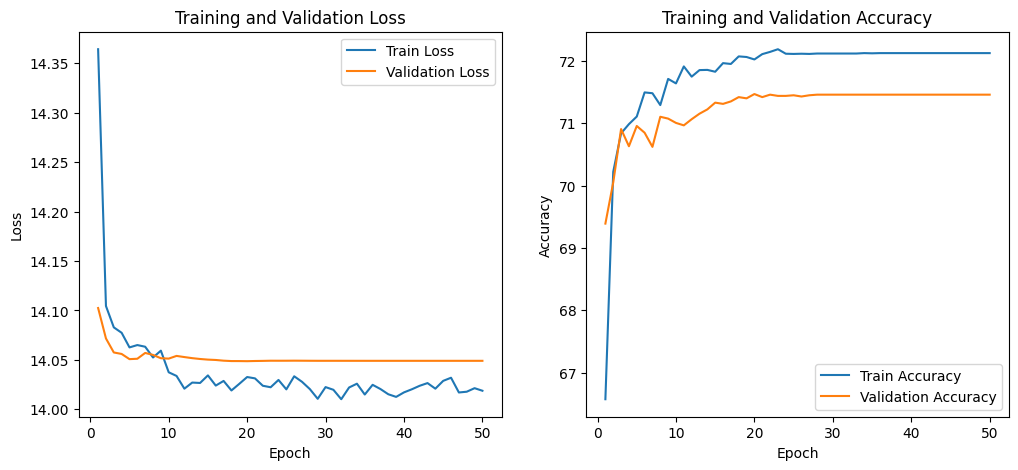

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)

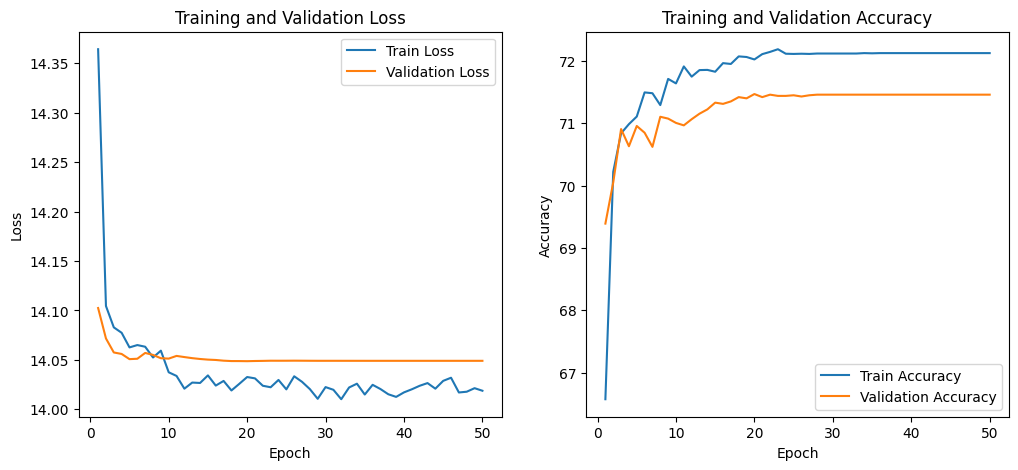

Test Accuracy: 0.7180725266062278


In [ ]:

# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training/validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Evaluate the model on the test set
accuracy = functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor)
print("Test Accuracy:", accuracy)